In [1]:
import numpy
from scipy import linalg, special, integrate
from scipy.integrate import solve_ivp
from matplotlib import pyplot
import matplotlib

#matplotlib.rc("font", **{"family":  "serif", "weight": "normal", "size": 20})

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": "28",
    "text.latex.preamble": "\\usepackage[utf8]{inputenc}\\usepackage[T1]{fontenc}\\usepackage{lmodern}"
})

from tqdm.notebook import tqdm

import joblib

import born_markov as bmme

In [12]:
def func_H_s(x):
    return numpy.diag([.5 * 0.003 * x[0]**2, .5 * 0.003 * x[0]**2 + .15 + .02 * x[0] * numpy.sqrt(2)])

def func_ddx_H_s(k, x):
    return numpy.diag([.003 * x[0], .003 * x[0] + .02 * numpy.sqrt(2)])

d_op = numpy.array([[0, 1], [0, 0]])

Gamma = .03
T = 174
voltage = 0.

x = numpy.linspace(-20, 10, 501)

mean_force = numpy.zeros(len(x), dtype=numpy.float64)
friction = numpy.zeros(len(x), dtype=numpy.float64)
correlation = numpy.zeros(len(x), dtype=numpy.float64)

def my_func(i, val):
    return bmme.calc_langevin_quantities(func_H_s, func_ddx_H_s, [val], [d_op], None, [[Gamma]], -.5 * voltage, .5 * voltage, T, T)

results = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func)(i, val) for i, val in enumerate(tqdm(x)))

for i in range(len(results)):
    if abs(results[i][0].imag) > 1e-10:
        print("ALARM!!! Mean force")
    else:
        mean_force[i] = results[i][0].real
    if abs(results[i][1].imag) > 1e-10:
        print("ALARM!!! Friction")
    else:
        friction[i] = results[i][1].real
    if abs(results[i][2].imag) > 1e-10:
        print("ALARM!!! Correlation")
    else:
        correlation[i] = results[i][2].real

        
pmf = numpy.zeros(len(x), dtype=numpy.float64)
for i in tqdm(range(len(x))):
    pmf[i] = -numpy.sum(mean_force[:i+1]) * (max(x) - min(x)) / (len(x) - 1)

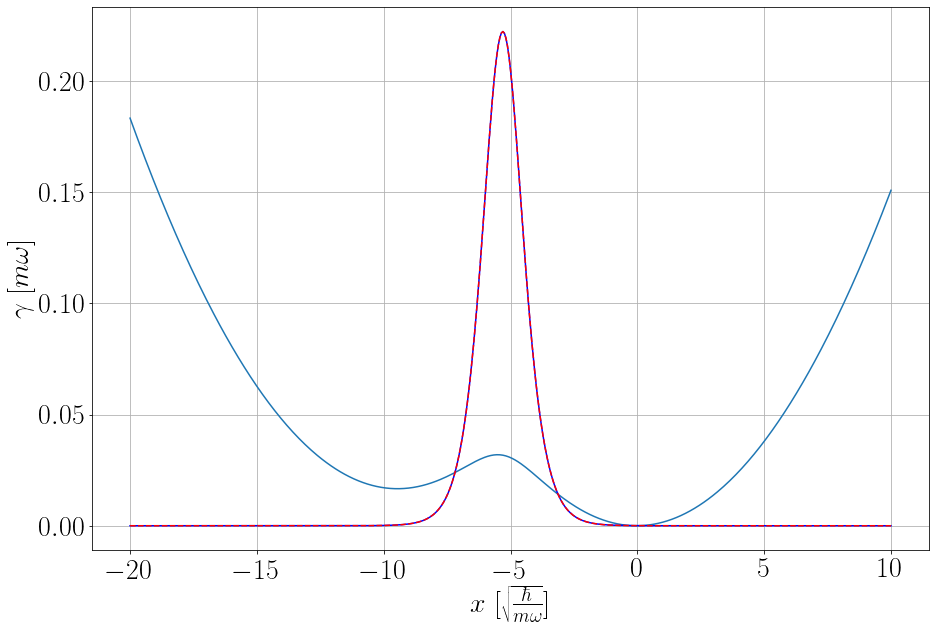

In [14]:
pyplot.figure(figsize=(15, 10))

pyplot.plot(x, pmf-min(pmf))
pyplot.plot(x, bmme._hbar * friction, c="blue")
pyplot.plot(x, bmme._hbar * correlation / (bmme.k_B * T), "--", c="red")
pyplot.xlabel("$x$ [$\\sqrt{\\frac{\\hbar}{m\\omega}}$]")
pyplot.ylabel("$\\gamma$ [$m\\omega$]")
pyplot.grid()
pyplot.show()